# Прогнозирование вероятности дефолта заемщика

Задача: построить скоринг модель для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента. 

# Импорт библиотек

In [75]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score, precision_score, recall_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [76]:
# фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы!
RANDOM_SEED = 42
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Импорт данных

In [77]:
#DATA_DIR = '../input/sf-dst-scoring/'
DATA_DIR = ''
df_train = pd.read_csv(DATA_DIR+'train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')

In [78]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # объединяем

In [79]:
print('df_train', df_train.shape)
print('df_test', df_test.shape)

df_train (73799, 20)
df_test (36349, 19)


# Анализ и подготовка данных

## 1. Первичный осмотр

Описание признаков:

client_id - идентификатор клиента  
education - уровень образования  
sex - пол заемщика  
age - возраст заемщика  
car - флаг наличия автомобиля  
car_type - флаг автомобиля иномарки  
decline_app_cnt - количество отказанных прошлых заявок  
good_work - флаг наличия “хорошей” работы  
bki_request_cnt - количество запросов в БКИ  
home_address - категоризатор домашнего адреса  
work_address - категоризатор рабочего адреса  
income - доход заемщика  
foreign_passport - наличие загранпаспорта  
sna - связь заемщика с клиентами банка  
first_time - давность наличия информации о заемщике  
score_bki - скоринговый балл по данным из БКИ  
region_rating - рейтинг региона  
app_date - дата подачи заявки  
default - флаг дефолта по кредиту  

In [80]:
data.head(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,NaN
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,NaN
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,NaN


In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

20 признаков:  
-5 категориальных  
-5 бинарных  
-7 числовых   
-1 временной "app_date"  
-1 целевая переменная "default"   
-1 искусственный признак "sample"  

Всего 110148 записей.   
Пропуски только в признаке "education" - 478

In [82]:
# Для удобства выделим категориальные,бинарные и числовые признаки в отдельные колонки
cat_cols = ['education', 'home_address', 'work_address',
            'sna', 'first_time']  # категориальные
bin_cols = ['sex', 'car', 'car_type',
            'foreign_passport', 'good_work']  # бинарные
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt',
            'income', 'region_rating', 'score_bki', 'days']  # числовые

## 2. Обработка NaN

In [83]:
data['education'].isnull().sum()

478

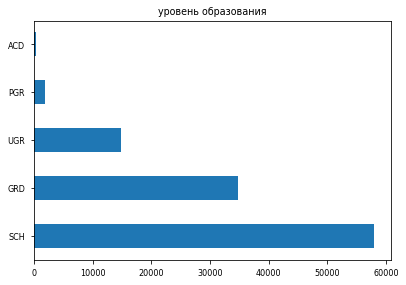

In [84]:
data['education'].value_counts().plot.barh(title='уровень образования')

Заполним самым популярным значением - 'SСH'

In [85]:
data['education'].fillna('SСH', inplace=True)

## 3. Анализ признаков

### Функции

In [86]:
# Проверка на выбросы
def show_outliers(column):
    col = data[column]
    IQR = col.quantile(0.75) - col.quantile(0.25)
    perc25 = col.quantile(0.25)
    perc75 = col.quantile(0.75)

    quan_low_outliers = len(data.query(f'{column} < {perc25 - 1.5*IQR}'))
    quan_high_outliers = len(data.query(f'{column} > {perc75 + 1.5*IQR}'))

    proc_low_outliers = round(quan_low_outliers/len(col) * 100, 2)
    proc_high_outliers = round(quan_high_outliers/len(col) * 100, 2)

    print('Колонка', column)
    print(
        f'Количество выбросов ниже нижней границы: {quan_low_outliers} ({proc_low_outliers}%)')
    print(
        f'Количество выбросов выше верхней границы: {quan_high_outliers} ({proc_high_outliers}%)')
    print('\n')

# временная трансформация education в числовой признак


def transform_to_int(x):
    if x == 'SCH':
        return 1
    elif x == 'GRD':
        return 2
    elif x == 'UGR':
        return 3
    elif x == 'PGR':
        return 4
    elif x == 'ACD':
        return 5
    else:
        return 0

# Чтобы не было ошибки, во временном датасете преобразуем категориальные и бинарные признаки в числовые. Делаем в отдельной функции,чтобы не хранить в оперативной памяти копию датасета.Либо можно воспользовать командой del


def show_mutual_info(data):
    data_temp = data.copy()

    label_encoder = LabelEncoder()
    for column in bin_cols:
        data_temp[column] = label_encoder.fit_transform(data_temp[column])

    data_temp['education'] = data_temp['education'].apply(transform_to_int)

    imp_cat = pd.Series(mutual_info_classif(data_temp.query('sample == 1')[cat_cols + bin_cols], data_temp.query('sample == 1')['default'],
                                            discrete_features=True), index=cat_cols + bin_cols)
    imp_cat.sort_values(inplace=True)
    imp_cat.plot(
        kind='barh', title='Значимость категориальных и бинарных признаков')

### Временные признаки

In [87]:
# переведём колонку в формат datetime
data['app_date'] = pd.to_datetime(data['app_date'])

In [88]:
print(data['app_date'].min(), data['app_date'].max())

2014-01-01 00:00:00 2014-04-30 00:00:00


Добавим признак количество дней от даты начала регистрации заявок

In [89]:
# доп колонка по дням улучшает ROC-AUC на 0.003
data['days'] = (data['app_date'] - data['app_date'].min()
                ).dt.days.astype('int64')

In [90]:
# Удалим признак app_date
data.drop('app_date', axis=1, inplace=True)

### Категориальные и бинарные признаки

Оценим значимость категориальных и бинарных признаков

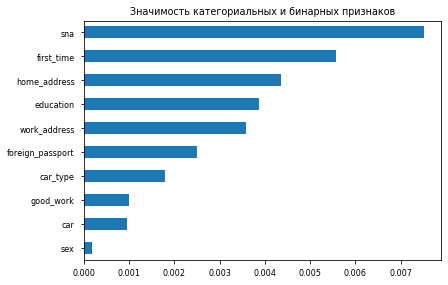

In [91]:
show_mutual_info(data)

Самым значимым из категориальных и бинарных признаков по mutual_info_classif является sna. Наименее значимым: sex.

### Числовые признаки

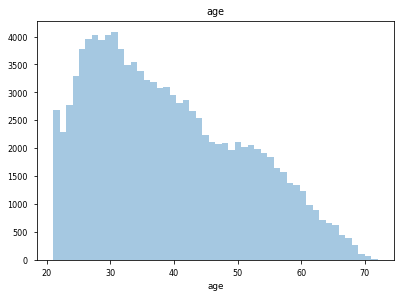

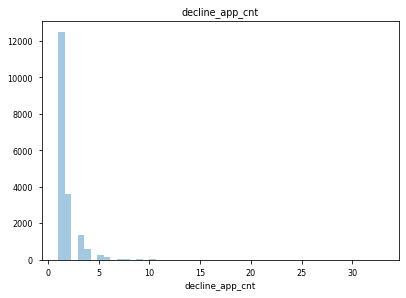

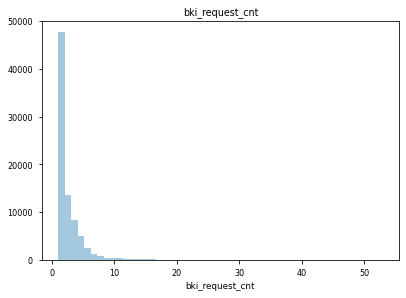

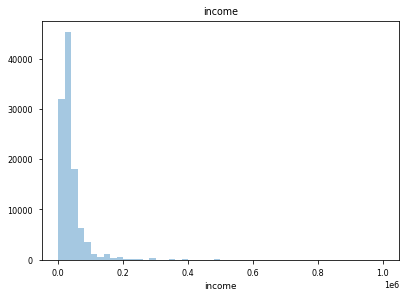

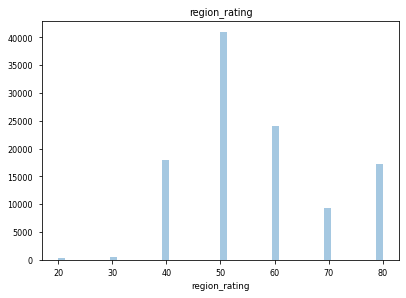

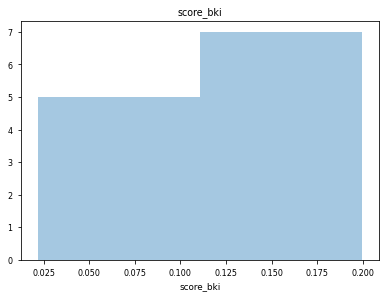

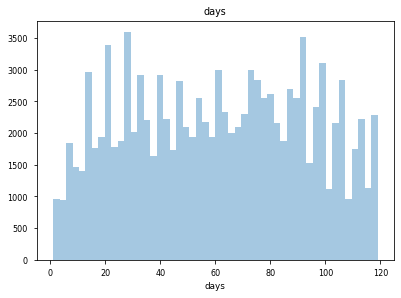

In [92]:
for i in num_cols:
    plt.figure()
    sns.distplot(data[i][data[i] > 0], kde=False, rug=False)
    plt.title(i)
    plt.show()

После построения гистограмм стало очевидно, что распределения почти всех числовых переменных имеют тяжёлый правый хвост

Логарифмируем числовые признаки, у которых неравномерное распределение

In [93]:
num_cols_log = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']

for column in num_cols_log:
    if len(data[column][data[column] < 0]) == 0:
        data[column] = np.log(data[column] + 1)

Построим boxplot’ы

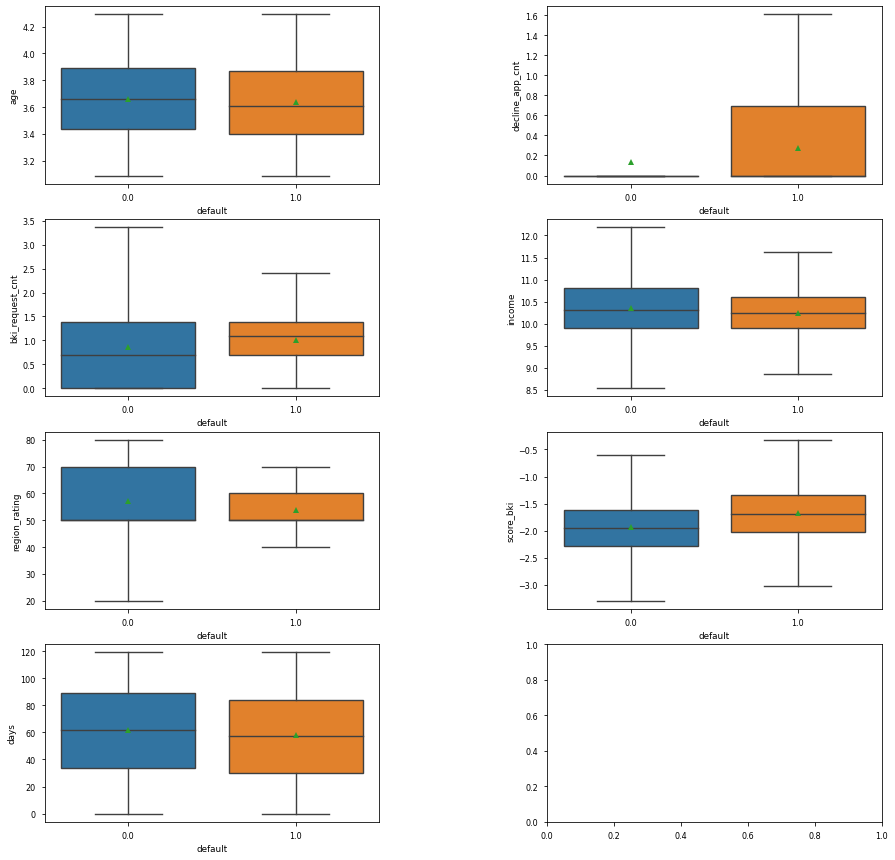

In [94]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()
for i in range(len(num_cols)):
    sns.boxplot(x="default", y=num_cols[i], data=data,
                orient='v', showmeans=True, ax=axes[i], showfliers=False)

In [95]:
# Описание признаков:

# client_id - идентификатор клиента
# education - уровень образования
# sex - пол заемщика
# age - возраст заемщика
# car - флаг наличия автомобиля
# car_type - флаг автомобиля иномарки
# decline_app_cnt - количество отказанных прошлых заявок
# good_work - флаг наличия “хорошей” работы
# bki_request_cnt - количество запросов в БКИ
# home_address - категоризатор домашнего адреса
# work_address - категоризатор рабочего адреса
# income - доход заемщика
# foreign_passport - наличие загранпаспорта
# sna - связь заемщика с клиентами банка
# first_time - давность наличия информации о заемщике
# score_bki - скоринговый балл по данным из БКИ
# region_rating - рейтинг региона
# app_date - дата подачи заявки
# default - флаг дефолта по кредиту

- Дефолтные клиенты в среднем младше  
- Дефолтные клиенты в среднем имеют большее количество отказанных заявок в прошлом
- Дефолтные клиенты в среднем имеют большее количество запросов в БКИ
- Дефолтные клиенты в среднем имеют меньше доход
- Дефолтные клиенты в среднем имеют меньший рейтинг региона
- Дефолтные клиенты в среднем имеют больший скоринговый балл по данным из БКИ 

Оценим значимость числовых признаков

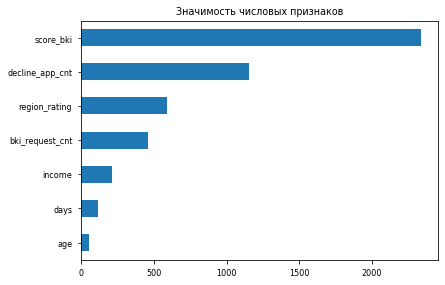

In [96]:
imp_num = pd.Series(f_classif(data.query('sample == 1')[num_cols], data.query(
    'sample == 1')['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh', title='Значимость числовых признаков')

Самыми значимыми из числовых признаков по f_classif является skore_bki. Наименее значимым: age.

Проверим на выбросы

In [97]:
for column in num_cols:
    show_outliers(column)

Колонка age
Количество выбросов ниже нижней границы: 0 (0.0%)
Количество выбросов выше верхней границы: 0 (0.0%)


Колонка decline_app_cnt
Количество выбросов ниже нижней границы: 0 (0.0%)
Количество выбросов выше верхней границы: 18677 (16.96%)


Колонка bki_request_cnt
Количество выбросов ниже нижней границы: 0 (0.0%)
Количество выбросов выше верхней границы: 15 (0.01%)


Колонка income
Количество выбросов ниже нижней границы: 875 (0.79%)
Количество выбросов выше верхней границы: 1734 (1.57%)


Колонка region_rating
Количество выбросов ниже нижней границы: 747 (0.68%)
Количество выбросов выше верхней границы: 17170 (15.59%)


Колонка score_bki
Количество выбросов ниже нижней границы: 82 (0.07%)
Количество выбросов выше верхней границы: 436 (0.4%)


Колонка days
Количество выбросов ниже нижней границы: 0 (0.0%)
Количество выбросов выше верхней границы: 0 (0.0%)




В целом выбросов не так много. Максимальные выбросы в признаке decline_app_cnt(16.96%). Удалять не будем.Посмотрим,как отработает модель.

Посмотрим корреляцию

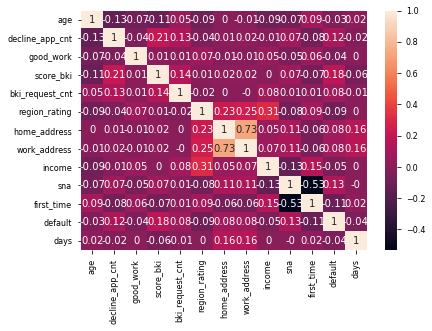

In [98]:
sns.heatmap(
    round(data.drop(['sample', 'client_id'], axis=1).corr(), 2), annot=True)

Низкая корреляция признаков.Их можно использовать в модели.   
Значительной корреляции признаков с целевой переменной нет.

## 4. Feature Engineering

Добавим новый признак "Количество отказанных заявок 0". (улучшил ROC-AUC на 0.0015)

In [99]:
data['decline_app_cnt_0'] = (data['decline_app_cnt'] == 0).astype('uint8')

Добавим новый признак "Высокий рейтинг региона"

In [100]:
data['region_rating_high'] = (data['region_rating'] >= 60).astype('uint8')

Добавим dummy переменные для категориальных признаков (улучшает ROC-AUC на 0.08)

In [101]:
data = pd.get_dummies(data, columns=cat_cols)

Разобьем бинарные признаки на 0 и 1 (улучшает ROC-AUC на 0.004)

In [102]:
label_encoder = LabelEncoder()
for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

Стандартизируем числовые признаки (улучшает ROC-AUC на 0.15)

In [103]:
data[num_cols] = pd.DataFrame(StandardScaler().fit_transform(
    data[num_cols].values), columns=num_cols)

## Корреляция модифицированных признаков

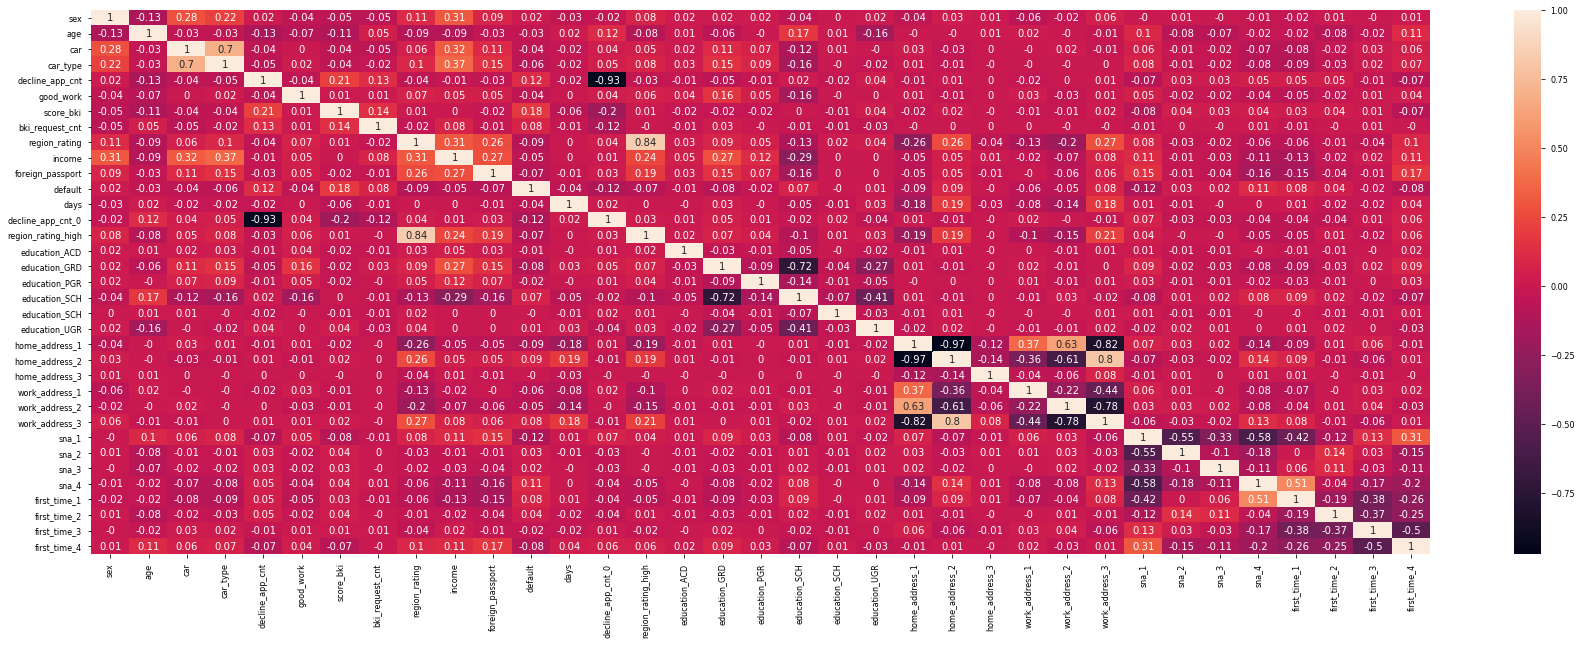

In [104]:
plt.rcParams['figure.figsize'] = (30, 10)
sns.heatmap(
    round(data.drop(['sample', 'client_id'], axis=1).corr(), 2), annot=True)
plt.rcParams['figure.figsize'] = (10, 5)

У home_address_1 сильная корреляция с work_address_3 и home_address_2.(-0.97) Можно было бы удалить home_address_1, это не повлияло бы на значение ROC-AUC,но уменьшило бы нагрузку при вычислениях.Правда после этого возрастает ошибка 1-го рода (значение FP в confusion matrix) и уменьшается TP. Поэтому не будем удалять признак home_address_1.   
Остальные признаки не сильно коррелированы между собой,поэтому их можно использовать в модели.   
Значительной корреляции признаков с целевой переменной нет.

In [105]:
# data.drop(['home_address_1'],axis=1,inplace=True)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [106]:
# на всякий случай, заново подгружаем данные
#DATA_DIR = '../input/sf-dst-scoring/'
DATA_DIR = ''
df_train = pd.read_csv(DATA_DIR+'train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')

df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # объединяем

# Для удобства выделим категориальные,бинарные и числовые признаки в отдельные колонки
cat_cols = ['education', 'home_address', 'work_address',
            'sna', 'first_time']  # категориальные
bin_cols = ['sex', 'car', 'car_type',
            'foreign_passport', 'good_work']  # бинарные
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt',
            'income', 'region_rating', 'score_bki', 'days']  # числовые

In [107]:
def preproc_data(df_input):

    df_output = df_input.copy()

    # ################### NAN ##############################################################
    df_output['education'].fillna('SCH', inplace=True)

    # ################### Feature Engineering ####################################################
    df_output['app_date'] = pd.to_datetime(df_output['app_date'])
    df_output['days'] = (df_output['app_date'] -
                         df_output['app_date'].min()).dt.days.astype('int64')
    df_output.drop('app_date', axis=1, inplace=True)

    df_output['decline_app_cnt_0'] = (
        df_output['decline_app_cnt'] == 0).astype('uint8')
    df_output['region_rating_high'] = (
        df_output['region_rating'] >= 60).astype('uint8')

    # ################### Encoding ##############################################################
    label_encoder = LabelEncoder()
    for column in bin_cols:
        df_output[column] = label_encoder.fit_transform(df_output[column])

    df_output = pd.get_dummies(df_output, columns=cat_cols)

    num_cols_log = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
    for column in num_cols_log:
        if len(data[column][data[column] < 0]) == 0:
            data[column] = np.log(data[column] + 1)

    df_output[num_cols] = pd.DataFrame(StandardScaler().fit_transform(
        df_output[num_cols].values), columns=num_cols)

    # ################### Clean ####################################################
    # убираем признаки которые еще не успели обработать,
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [
        s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis=1, inplace=True)

    # df_output.drop(['home_address_1'],axis=1,inplace=True)

    return df_output

In [108]:
df_preproc = preproc_data(data)

In [109]:
df_preproc = preproc_data(data)

# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample', 'default'], axis=1)

X = train_data.drop(['default', 'client_id'], axis=1)
y = train_data['default'].values

# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((36349, 34), (73799, 35), (73799, 33), (59039, 33), (14760, 33))

# Model

## 1. Функции

In [110]:
# Вывод понятной confusion_matrix(
def confusion_matrix_f(d_name_columns, y_true, y_pred, title='Матрица ошибок'):

    classes = np.array(d_name_columns, dtype='U10')
    list_of_labels = [['TP', 'FP'], ['FN', 'TN']]

    cm = confusion_matrix(y_true, y_pred)

    cm[0, 0], cm[1, 1] = cm[1, 1], cm[0, 0]

    plt.style.use('seaborn-paper')
    cmap = plt.cm.Blues
    color_text = plt.get_cmap('PuBu')(0.85)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           title=title)

    ax.title.set_fontsize(15)
    ax.set_ylabel('Предсказанные значения', fontsize=14, color=color_text)
    ax.set_xlabel('Актуальные значения', fontsize=14, color=color_text)
    ax.set_xticklabels(classes, fontsize=12, color='black')
    ax.set_yticklabels(classes, fontsize=12, color='black')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, list_of_labels[i][j]+'\n'+format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
# Вывод понятной confusion_matrix)

# Вывести метрики(


def all_metrics(y_true, y_pred, probs):

    metrics_dict = {}
    metrics_dict['accuracy'] = [
        accuracy_score(y_true, y_pred), '(TP+TN)/(P+N)']
    metrics_dict['precision'] = [precision_score(
        y_true, y_pred), 'точность TP/(TP+FP)']
    metrics_dict['recall'] = [recall_score(
        y_true, y_pred), 'полнота TP/(TP+FN)']
    metrics_dict['f1_score'] = [
        f1_score(y_true, y_pred), '2*(precision*recall)/(precision+recall)']
    metrics_dict['roc_auc'] = [roc_auc_score(y_true, probs), 'roc_auc']

    df_tmp = pd.DataFrame.from_dict(
        metrics_dict, orient='index', columns=['Значение', 'Описание'])
    display(df_tmp)
# Вывести метрики)

## 2.Реализация

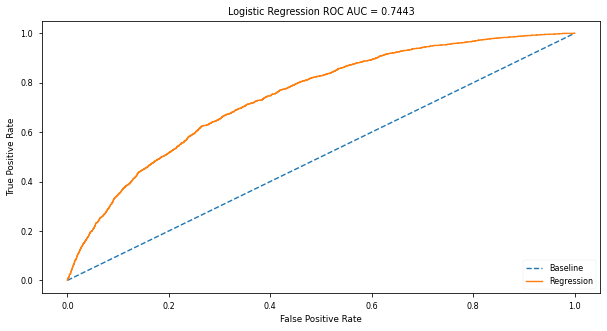

,Значение,Описание
accuracy,0.875068,(TP+TN)/(P+N)
precision,0.415842,точность TP/(TP+FP)
recall,0.022989,полнота TP/(TP+FN)
f1_score,0.043568,2*(precision*recall)/(precision+recall)
roc_auc,0.744329,roc_auc


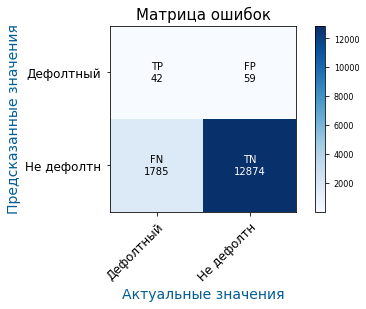

In [111]:
model = LogisticRegression()
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:, 1]

y_pred = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.rcParams['figure.figsize'] = (10, 5)
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.4f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

all_metrics(y_test, y_pred, probs)
confusion_matrix_f(['Дефолтный', 'Не дефолтный'],
                   y_test, y_pred, 'Матрица ошибок')

Хотя значение ROC-AUC само по себе достаточно высокое, но остальные метрики показывают, что модель не готова к боевым задачам. Об этом свидетельствует низкие recall и f1_score.

Попробуем поработать с гиперпараметрами.

In [112]:
# Закомменитировал,так как отрабатывает долго.

# %%time

# # Добавим типы регуляризации
# #penalty = ['l1','l2']
# penalty = ['l2']
# #multi_class = ['auto', 'ovr', 'multinomial']
# multi_class = ['auto']
# #C = [x for x in range(-10,10,1)]
# C = [1]
# #class_weight = ['balanced',None]
# class_weight = ['balanced']
# #max_iter = [x for x in range(100,2000,100)]
# max_iter = [1000]
# #solver= ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# solver = ['lbfgs']

# # Создадим гиперпараметры
# hyperparameters = dict(C=C, penalty=penalty,class_weight=class_weight,multi_class=multi_class,max_iter=max_iter
#                       ,solver=solver)

# model = LogisticRegression()
# model.fit(X_train, y_train)

# # Создаем сетку поиска с использованием 10-кратной перекрестной проверки
# clf = GridSearchCV(model, hyperparameters,scoring='roc_auc', cv=10, verbose=0)

# best_model = clf.fit(X_train, y_train)

# probs = best_model.predict_proba(X_test)
# probs = probs[:,1]

# y_pred = best_model.predict(X_test)

# fpr, tpr, threshold = roc_curve(y_test, probs)
# roc_auc = roc_auc_score(y_test, probs)

# plt.figure()
# plt.plot([0, 1], label='Baseline', linestyle='--')
# plt.plot(fpr, tpr, label = 'Regression')
# plt.title('Logistic Regression ROC AUC = %0.4f' % roc_auc)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.legend(loc = 'lower right')
# plt.show()

# # View best hyperparameters
# print('Лучшие параметры:', best_model.best_estimator_.get_params())

# all_metrics(y_test,y_pred,probs)
# confusion_matrix_f(['Дефолтный','Не дефолтный'], y_test, y_pred, 'Матрица ошибок')

In [113]:
# Закомментировал,т.к. ROC-AUC хуже

# model = LogisticRegression(class_weight = 'balanced')
# model.fit(X_train, y_train)

# probs = model.predict_proba(X_test)
# probs = probs[:,1]

# y_pred = model.predict(X_test)

# fpr, tpr, threshold = roc_curve(y_test, probs)
# roc_auc = roc_auc_score(y_test, probs)

# plt.rcParams['figure.figsize'] = (10,5)
# plt.figure()
# plt.plot([0, 1], label='Baseline', linestyle='--')
# plt.plot(fpr, tpr, label = 'Regression')
# plt.title('Logistic Regression ROC AUC = %0.4f' % roc_auc)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.legend(loc = 'lower right')
# plt.show()

# all_metrics(y_test,y_pred,probs)
# confusion_matrix_f(['Дефолтный','Не дефолтный'], y_test, y_pred, 'Матрица ошибок')

В ходе тестирования гиперпараметров для модели LogisticRegression в GridSearchCV получились следующие выводы:
параметры по-умолчанию дали наиболее высокий ROC-AUC.  
Гиперпараметр class_weight = 'balanced' значительно улучшил метрики recall и f1_score, но немного снизил ROC-AUC.  
Для боевой задачи я бы использовал class_weight = 'balanced', но так как основная цель набрать более высокий ROC-AUC,оставлю параметры по-умолчанию.

# Submission

In [114]:
y_pred_probs = model.predict_proba(test_data.drop('client_id', axis=1))[:, 1]
submit = pd.DataFrame(
    {'client_id': test_data['client_id'], 'default': y_pred_probs})

print(submit.shape)
submit.head(5)

(36349, 2)


,client_id,default
0,74835,0.037796
1,17527,0.324006
2,75683,0.057371
3,26883,0.095580
4,28862,0.026279


In [115]:
submit.to_csv('submission.csv', index=False)